# Rapid introduction on using numpy, scipy, matplotlib

This is meant to be a very brief reminder. It is strongly suggested to refer to more detailed
introductions and tutorials see for instance:
- [A Whirlwind tour of Python](http://nbviewer.jupyter.org/github/jakevdp/WhirlwindTourOfPython/blob/master/Index.ipynb)
- [Python data science handbook](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/Index.ipynb)

## Introduction

Here we will look at :
- basic features regarding array manipulation and indexing
- do a bit of plotting with matplotlib
- use a number of useful scipy features
- see an example of vectorization with a simple Monte Carlo problem

## numpy: arrays, indexing etc



In [2]:
import numpy as np


In [26]:
x = np.array([3,4,5])
print x
y = np.array([[1, 2],[3,4]])
print y

[3 4 5]
[[1 2]
 [3 4]]


In [27]:
### linearly spaced 1D array
print np.linspace(1.,10.,10)

### log spaced 1D array
print np.logspace(0.,1.,10)


[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
[  1.           1.29154967   1.66810054   2.15443469   2.7825594
   3.59381366   4.64158883   5.9948425    7.74263683  10.        ]


In [23]:
### 1D array of zeros
print np.zeros(5)

### 2D array of zeros
print np.zeros((3,3))

[ 0.  0.  0.  0.  0.]
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


### Types and casts

See numpy [dtypes](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html)

In [44]:
x_int = np.logspace(0.,1.,10).astype('int')   # cast array as int
print x_int

x_int[1]=2.34   # 2.34 is cast as int
print x_int[1]

[ 1  1  1  2  2  3  4  5  7 10]
2


In [52]:
array_string = np.array(['a','b','c','d'])
print array_string.dtype    # 1 character string

array_string[1]='bbbb'   # 'bbbb' is cast on 1 character string
print array_string[1]

array_string = np.array(['a','b','c','d'],dtype=np.dtype('S10'))
array_string[1]='bbbb'   # 'bbbb' is cast on 10 character string
print array_string[1]


|S1
b
bbbb


### array indexing & slicing

In [57]:
x = np.arange(10)

print x[-1]   # last element

print x[3:6]  # subarray

print x[1::2] # stride

print x[::-1] # stride


9
[3 4 5]
[1 3 5 7 9]
[9 8 7 6 5 4 3 2 1 0]


In [92]:
x = np.array([np.arange(10*i,10*i+5) for i in range(5)])
print x

print "first column : ", x[:,0]
print "last row     : ", x[-1,:]


[[ 0  1  2  3  4]
 [10 11 12 13 14]
 [20 21 22 23 24]
 [30 31 32 33 34]
 [40 41 42 43 44]]
first column :  [ 0 10 20 30 40]
last row     :  [40 41 42 43 44]


In [93]:
b=x[-1,:]   # This is a view not a copy!
b[:] += 1

print x  # the initial matrix is changed!


[[ 0  1  2  3  4]
 [10 11 12 13 14]
 [20 21 22 23 24]
 [30 31 32 33 34]
 [41 42 43 44 45]]


In [94]:
# Fancy indexing 
print x%2==1
x[x%2==1]=0
print x

[[False  True False  True False]
 [False  True False  True False]
 [False  True False  True False]
 [False  True False  True False]
 [ True False  True False  True]]
[[ 0  0  2  0  4]
 [10  0 12  0 14]
 [20  0 22  0 24]
 [30  0 32  0 34]
 [ 0 42  0 44  0]]


### Broadcasting

In [83]:
x=np.linspace(1,5,5) + 4   # 4 is broadcast to 5 element array
print x

[ 5.  6.  7.  8.  9.]


In [84]:
y=np.zeros((3,5)) + x   # x is broadcast to (3,5) array
print y

[[ 5.  6.  7.  8.  9.]
 [ 5.  6.  7.  8.  9.]
 [ 5.  6.  7.  8.  9.]]


## Plotting with matplotlib

We will see some plotting:
- Simple plots
- Histograms with matplotlib

In [88]:
# This is for embedding figures in the notebook
%matplotlib inline   
import matplotlib.pyplot as plt
plt.style.use('ggplot')         # Fancy style


## Vectorization or loops: A very simple MC

We want to solve a simple statistical question. Assume a Poisson random process of mean mu. What is the density probability function pdf(n_val) of having at least one realization of the Poisson process out of N larger than n_val? 

See for instance [this paper](https://arxiv.org/pdf/0903.4373.pdf)

While this problem has an analytical solution we would like to test it with a simple MC. 

We will first do it as one would do it with a C code and we will progressively vectorize the problem. We will use a timer to compare performance.



In [5]:
### Define the function
def Poisson_sample_maximum(mu, N, Ntrials):
    """
        Generate a set of Ntrials random variables defined as the maximum of N 
        random Poisson R.V. of mean mu
        __________
        Input:
            - mu: float 
                  the mean value of the Poisson process
            - N : int 
                  the number of Poisson R.V. on which we take the maximum 
            - Ntrials: int
                  the number of variables to compute
    """
    res = np.zeros(Ntrials)
    ### Do a loop
    for i in range(Ntrials):
        ### Generate N random varslues 
        Y = np.random.poisson(mu,size=(N))
        ### Take the maximum 
        res[i] = np.max(Y)

    return res 
   
mu = 5
N = 10
Ntrials = 1000000
    
%timeit values = Poisson_sample_maximum(mu,N,Ntrials)


1 loops, best of 3: 5.18 s per loop


It does work, but no so fast...

To do it in a efficient and pythonic way we have to avoid loops as much as possible.

The idea here will then be to do all trials at once requiring random.poisson to produce a 2D matrix of size Nxtrials

In [10]:
### Define a better function
def Poisson_sample_maximum_better(mu, N, Ntrials):
    """
        Generate a set of Ntrials random variables defined as the maximum of N 
        random Poisson R.V. of mean mu
        __________
        Input:
            - mu: float 
                  the mean value of the Poisson process
            - N : int 
                  the number of Poisson R.V. on which we take the maximum 
            - Ntrials: int
                  the number of variables to compute
    """
    ### Generate N*Ntrials random values in N x Ntrials matrix
    Y = np.random.poisson(mu,size=(N,Ntrials))
    ### Return the maximum in each row
    return np.max(Y,0)

   
mu = 5
N = 10
Ntrials = 1000000
    
%timeit values = Poisson_sample_maximum_better(mu,N,Ntrials)


1 loops, best of 3: 931 ms per loop


We can now compare the distribution of MC simulated values to the actual analytical function.


(1e-06, 1)

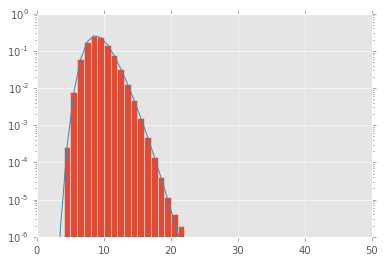

In [29]:
### Make and plot the normalized histogram
### We define the binning ouselves to have bins for each integer
bins = np.arange(0,10*mu)
histo = plt.hist(values,bins=bins,normed=True,log=True)

### Now compare to the analytical solution
from scipy.special import gammaincc

### Define a lambda function to compute analytical solution
proba = lambda nv, Nr, mu_p :  gammaincc(nv+1, mu_p)**Nr-gammaincc(nv, mu_p)**Nr

plt.plot(0.5*(bins[:-1]+bins[1:]),proba(bins[:-1],N,mu))
plt.ylim(1e-6,1)   # restrict y range

**Exercice**: write a vectorized function that takes an array of int and returns an array where square integers are replaced by their square root and the others are left unchanged

In [104]:
### A solution
def replace_square(n):
    sqrt_n = np.sqrt(n)
    return n + (sqrt_n == sqrt_n.astype(int))*(-n + sqrt_n)

print replace_square(7.0)        
print replace_square(np.arange(26))

7.0
[  0.   1.   2.   3.   2.   5.   6.   7.   8.   3.  10.  11.  12.  13.  14.
  15.   4.  17.  18.  19.  20.  21.  22.  23.  24.   5.]


In [105]:
### or using where
def replace_square2(n):
    sqrt_n = np.sqrt(n)
    return np.where(sqrt_n == sqrt_n.astype(int), 
                    sqrt_n, n)
        
print replace_square2(7.0)        
print replace_square2(np.arange(26))

7.0
[  0.   1.   2.   3.   2.   5.   6.   7.   8.   3.  10.  11.  12.  13.  14.
  15.   4.  17.  18.  19.  20.  21.  22.  23.  24.   5.]
